# Exercise 1: Exploring the CPS data set

We will use data from the Chicago Data Portal on Chicago Public Schools (CPS).  The data is available on our GitHub repo in the `data/` directory.  The tasks are:

1. Merge the 2 dataframes on GitHub using the “School_ID” column.
2. Create new columns in the merged dataframe that show the percentage of students in various categories, rather than the raw student counts (columns beginning with “Student_Count”). 
3. Create a correlation matrix for all the columns that have numerical values.
4. Print out any strong correlations that you find interesting.
5. Check at least one of these correlations by plotting a scatter plot that also shows a linear regression line.


Below is my version of solving this exercise in Python.

My series of prompts:

>I am working in Python with pandas.  I have two dataframes that I want to join.  They both have the column "School_ID", and I want to use that to match the rows.  How do I code this in Python?

>In my dataframe, there are many columns with names that start with the string "Student_Count".  For all of these columns, I want to create a new column whose name is the same but with "Percent" instead of "Count" and the value divided by the value in another column names "Student_Count_Total".  How do I code this with python and pandas?

>I have a dataframe with many columns.  Some columns are continuous numeric.  Others are numeric and categorical.  Still others are categorical but with text values.  There are also many empty cells.  I want to select only the columns with numerical types, and then check for any correlations between them.  For the correlations, I need to ignore NaN values.  How do I do this using pandas?

>For the correlation matrix, I want to only look at one triangle.  I don't want to see the duplicate correlation (e.g., for X vs. Y and Y vs. X, I only want X vs. Y).  How do I do that?

>Now I want to print all the pairs of columns that have a correlation value greater than some threshold.  I'll set the threshold at 0.5 initially.  How do I code this?

>I'm using most of your code, but I'm printing in a loop:
>
>
>```
>for i,row in filtered_pairs.iterrows():
>    print(f'{row["col1"]}, {row["col2"]} : {row["correlation"]}')
>```
>
>Within that loop I want to check if the row["col1"] and row["col2"] values are similar to within some tolerance.  (They are strings.)  If they are too similar, I will not print the row.  How do I code this with a built-in python function?

>Now I want to create a scatter plot for two columns in my dataframe.  In that scatter plot I also want to show a linear regression line.  I also want to modify the plot title and axis labels and save my figure as a png.  How do I do this in seaborn?

I then pieced together the code below:

In [106]:
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [79]:
# merge the dataframes
df1 = pd.read_csv('data/Chicago_Public_Schools_-_School_Progress_Reports_SY2324_20240924.csv')
df2 = pd.read_csv('data/Chicago_Public_Schools_-_School_Profile_Information_SY2324_20240924.csv')
merged_df = pd.merge(df1, df2, on='School_ID', how='inner')  # 'inner' is the default

# Iterate over columns that start with "Student_Count" and create the percent columns
for col in merged_df.columns:
    if col.startswith("Student_Count"):
        # Create new column name
        new_col_name = col.replace("Count", "Percent")
        # Calculate the percentage
        merged_df[new_col_name] = merged_df[col]/merged_df["Student_Count_Total"]*100

In [88]:
corr_threshold = 0.8
string_threshold = 0.5

# Step 1: Select only numerical columns
numerical_cols = merged_df.select_dtypes(include=['number'])

# Step 2: Calculate the correlation matrix, automatically ignores NaN values
correlation_matrix = numerical_cols.corr(method='pearson')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # For upper triangle

# Apply the mask to the correlation matrix
upper_triangle = correlation_matrix.where(mask)

# Step 3: Find pairs with correlation greater than 0.5
correlation_pairs = upper_triangle.unstack().reset_index()
correlation_pairs.columns = ['col1', 'col2', 'correlation']

# Step 4: Filter out self-correlations and duplicates
filtered_pairs = correlation_pairs[(correlation_pairs['col1'] != correlation_pairs['col2']) &
                                   (abs(correlation_pairs['correlation']) > corr_threshold)]

# Step 5: Sort by correlation value in descending order
filtered_pairs = filtered_pairs.sort_values(by='correlation', ascending=False).drop_duplicates()

# Step 6: Display the result, 
for i,row in filtered_pairs.iterrows():
    similarity = similar(row["col1"], row["col2"]) 

    # Only show those that have different enough column names
    if (similarity < string_threshold):
    # Alternatively, also select only correlations that include my "Student_Percent" columns
    # if ((similarity < string_threshold) and (("Student_Percent" in row["col1"]) or ("Student_Percent" in row["col2"]))):
        print(f'{row["col1"]}, {row["col2"]} : {row["correlation"]}')



Mobility_Rate_Pct, One_Year_Dropout_Rate_Year_2_Pct : 0.9498286658565717
Student_Percent_Asian_Pacific_Islander, Student_Count_Ethnicity_Not_Available : 0.8938659894350571
Fax_y, Phone_y : 0.8327960786191722
Chronic_Truancy_Pct, Student_Attendance_Year_1_Pct : -0.8242456172774841
College_Enrollment_Rate_School, Mobility_Rate_Pct : -0.8265077928901008
Mobility_Rate_Pct, College_Enrollment_School_Pct_Year_1 : -0.8265077928901008
Graduation_Rate_School, Mobility_Rate_Pct : -0.8453442449425482
Mobility_Rate_Pct, Graduation_5_Year_School_Pct_Year_1 : -0.8453442449425482
Chronic_Truancy_Pct, Student_Attendance_Year_2_Pct : -0.8819669739483893
Graduation_5_Year_School_Pct_Year_2, Suspensions_Per_100_Students_Year_1_Pct : -0.9509851673280011
Graduation_Rate_School, Suspensions_Per_100_Students_Year_1_Pct : -0.9514042289065215
Graduation_5_Year_School_Pct_Year_1, Suspensions_Per_100_Students_Year_1_Pct : -0.9514042289065215


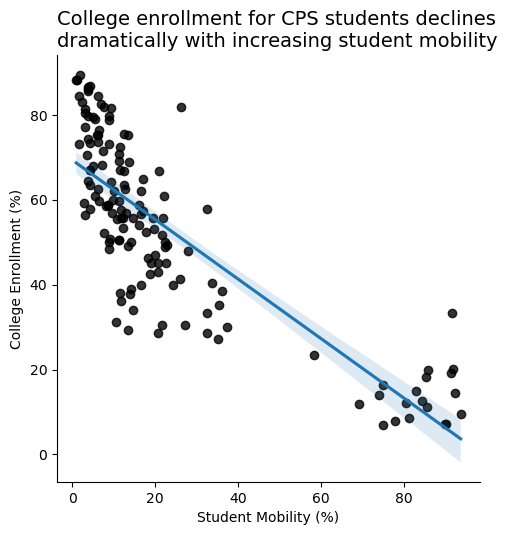

In [119]:
sns.lmplot(data=merged_df, x='Mobility_Rate_Pct', y='College_Enrollment_School_Pct_Year_1', scatter_kws={'color': 'black'})
plt.title('College enrollment for CPS students declines\ndramatically with increasing student mobility', loc='left', fontsize=14)
plt.xlabel('Student Mobility (%)')
plt.ylabel('College Enrollment (%)')

plt.savefig('CPS_correlation.png', bbox_inches='tight')